In [ ]:
import pandas as pd
import io
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
vcf = "samples.txt"

with open(vcf) as f:
    lines = [l for l in f if not l.startswith("##")]

df = pd.read_csv(io.StringIO("".join(lines)),sep="\t")
samples = df.columns[9:]

snp_ids = (
    df["#CHROM"].astype(str)
    + "_"
    + df["POS"].astype(str)
    + "_"
    + df["REF"]
    + ">"
    + df["ALT"]
)

X = df[samples].astype(int).T

X.columns = snp_ids.values

print(X.shape)

(103, 4544)


In [ ]:
pheno = pd.read_excel("biofilm_phenotype.xlsx")

common_ids = X.index.intersection(pheno['Sample_ID'])

y = pheno[pheno['Sample_ID'].isin(common_ids)].set_index("Sample_ID").loc[common_ids, "BFI"].values
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0
 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1]


In [ ]:
X = X.loc[common_ids]
X = X.loc[:, X.var() > 0]
maf = X.mean(axis=0)
X = X.loc[:, (maf > 0.01) & (maf < 0.99)]
X.isnull().sum()
X.head(10)

,NC_010079.1_930_C>T,NC_010079.1_954_G>A,NC_010079.1_966_G>A,NC_010079.1_2608_G>A,NC_010079.1_2725_C>T,NC_010079.1_4872_A>G,NC_010079.1_4886_C>T,NC_010079.1_5297_A>G,NC_010079.1_6047_T>C,NC_010079.1_6076_G>A,...,NC_010079.1_2859814_G>A,NC_010079.1_2859815_C>T,NC_010079.1_2859960_G>A,NC_010079.1_2868059_G>A,NC_010079.1_2868229_C>T,NC_010079.1_2868295_C>T,NC_010079.1_2869057_A>G,NC_010079.1_2870368_A>G,NC_010079.1_2871139_A>G,NC_010079.1_2871315_A>G
CA_001,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
CA_010,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
CA_011,1,1,1,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,0
CA_012,1,1,1,1,1,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0
CA_013,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
CA_014,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
CA_016,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
CA_018,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
CA_019,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
CA_002,1,1,1,1,1,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0


In [ ]:
class SVM_linear:

    def __init__(self, alpha=0.0001, lambda_=0.001, n_iterations=1000):
        self.alpha = alpha
        self.lambda_ = lambda_
        self.n_iterations = n_iterations
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iterations):
            for i in range(n_samples):
                Xi = X.iloc[i]
                yi = y[i]

                condition = yi * (np.dot(self.w, Xi) - self.b)

                if condition >= 1:
                    self.w -= self.alpha * (2 * self.lambda_ * self.w)
                else:
                    self.w -= self.alpha * (2 * self.lambda_ * self.w - yi * Xi)
                    self.b -= self.alpha * yi

    def predict(self, X):
        scores = np.dot(X, self.w) - self.b
        return np.where(scores >= 0, 1, -1)

In [ ]:
y_svm = np.where(y == 1, 1, -1)


In [ ]:
X_mean = X.mean(axis=0)
X_std  = X.std(axis=0)

X_scaled = (X - X_mean) / X_std


In [ ]:
alphas = [0.0001, 0.001, 0.01]
lambdas = [0.001, 0.01, 0.1]

best_score = 0
best_params = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for alpha in alphas:
    for lambda_ in lambdas:
        f1_scores = []
        for train_idx, val_idx in kf.split(X_scaled, y_svm):
            X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
            y_train, y_val = y_svm[train_idx], y_svm[val_idx]

            svm = SVM_linear(alpha=alpha, lambda_=lambda_, n_iterations=1000)
            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_val)

            f1 = (2 * ((y_pred == 1) & (y_val == 1)).sum()) / ((y_pred == 1).sum() + (y_val == 1).sum() + 1e-8)
            f1_scores.append(f1)

        mean_f1 = np.mean(f1_scores)
        if mean_f1 > best_score:
            best_score = mean_f1
            best_params = {'alpha': alpha, 'lambda_': lambda_}

print("Best params:", best_params)
print("Best CV F1:", best_score)

KeyboardInterrupt: 

In [ ]:
svm = SVM_linear(alpha=0.0001, lambda_=0.001, n_iterations=1000)
svm.fit(X_scaled, y_svm)
y_pred = svm.predict(X_scaled)

In [ ]:
y_pred_biofilm = np.where(y_pred == 1, 1, 0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_svm, test_size=0.2, random_state=42)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = (y_pred == y_test).mean()
print("Test Accuracy:", accuracy)



Test Accuracy: 0.7142857142857143


In [ ]:
y_svm = np.where(y == 1, 1, -1)

X = X.copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for train_idx, test_idx in skf.split(X, y_svm):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_svm[train_idx], y_svm[test_idx]

    X_mean = X_train.mean(axis=0)
    X_std  = X_train.std(axis=0) + 1e-8
    X_train_scaled = (X_train - X_mean) / X_std
    X_test_scaled  = (X_test  - X_mean) / X_std

    svm = SVM_linear(alpha=0.0001, lambda_=0.001, n_iterations=1000)
    svm.fit(X_train_scaled, y_train)

    preds = svm.predict(X_test_scaled)

    f1_fold = f1_score(y_test, preds, pos_label=1)
    f1_scores.append(f1_fold)

print("Mean CV F1:", np.mean(f1_scores))
print("Std CV F1:", np.std(f1_scores))

Mean CV F1: 0.8296807710347263
Std CV F1: 0.0450023887329679


In [ ]:
weights = svm.w
top_snps = np.argsort(np.abs(weights))[-20:]

important_snps = X.columns[top_snps]
print(important_snps)


Index(['NC_010079.1_284213_A>G', 'NC_010079.1_2155236_G>A',
       'NC_010079.1_596471_T>C', 'NC_010079.1_2369787_G>A,T',
       'NC_010079.1_2521809_G>A', 'NC_010079.1_315365_A>T',
       'NC_010079.1_2673150_C>T', 'NC_010079.1_2699045_C>T',
       'NC_010079.1_221631_T>C', 'NC_010079.1_2695018_G>T',
       'NC_010079.1_2667291_T>C', 'NC_010079.1_2560231_G>T',
       'NC_010079.1_2821552_T>C', 'NC_010079.1_2081410_T>G',
       'NC_010079.1_1079244_T>A', 'NC_010079.1_214091_A>C',
       'NC_010079.1_2741879_A>G', 'NC_010079.1_428376_A>G',
       'NC_010079.1_406109_C>T', 'NC_010079.1_2694764_G>A'],
      dtype='object')


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

svm_rbf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    svm_rbf,
    X_train,
    y_train,
    cv=cv,
    scoring='f1'
)

print("Mean CV F1:", scores.mean())
print("Std CV F1:", scores.std())


Mean CV F1: 0.8688998357963875
Std CV F1: 0.025997243630820704


In [ ]:
svm_rbf.fit(X_train, y_train)
y_predd = svm_rbf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_predd))
print("Test F1:", f1_score(y_test, y_predd))

Test Accuracy: 0.8
Test F1: 0.875


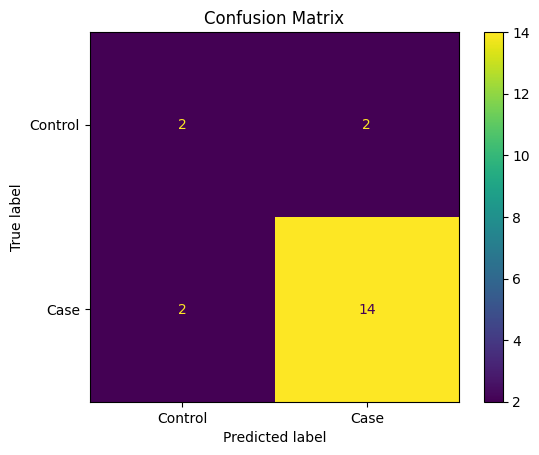

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_predd)

# Plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Control", "Case"]
)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

